# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

import coco
import utils
import model as modellib
import visualize

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

/Users/m_654132/Code/src/github.com/CognizantStudio/lp02-team-l-engine/venv/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [2]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           coco
NUM_CLASSES                    81
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINI

## Create Model and Load Trained Weights

In [3]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [7]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Run Object Detection

Processing 1 images
image                    shape: (427, 640, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000
masks
(427, 640, 11)
rois
[[ 36   0 369 359]
 [198 411 250 430]
 [196 146 258 193]
 [189 442 312 580]
 [196 427 231 437]
 [235   0 423 170]
 [201 358 253 382]
 [195 364 240 408]
 [173 367 205 416]
 [146 441 218 507]
 [135  46 175 116]]
(11, 4)


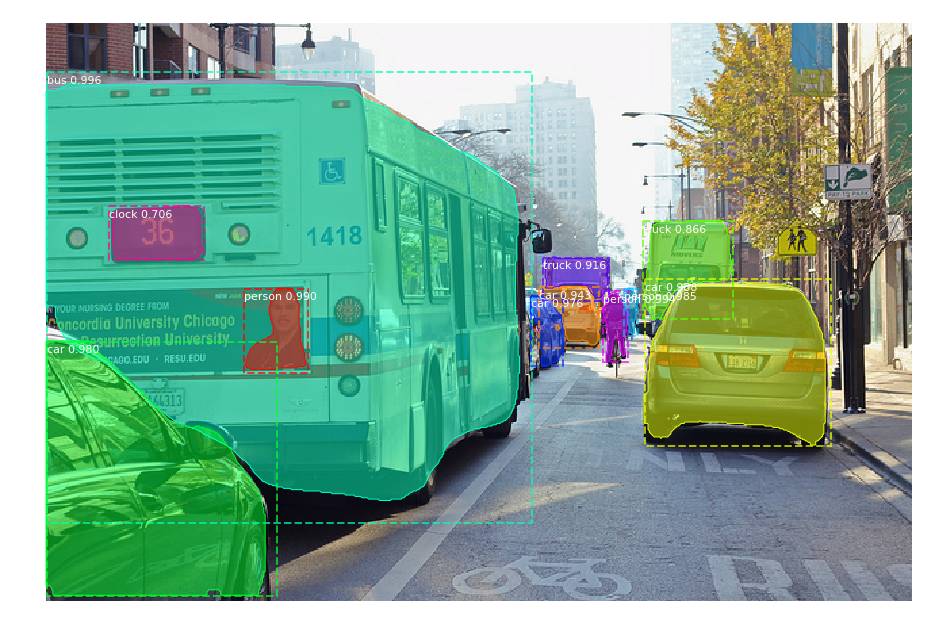

In [8]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]

# Some information about the masks and ROIs
print('masks')
#print(r['masks'])
print(r['masks'].shape)
print('rois')
print(r['rois'])
print(r['rois'].shape)

visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
creating index...
index created!
description: Subset of COCO 2017 Dataset
url: http://cocodataset.org
version: 1.0
year: 2017
contributor: COCO Consortium
date_created: 2017/09/01

img_id 581062

imgs [{'license': 1, 'file_name': '000000581062.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000581062.jpg', 'height': 375, 'width': 500, 'date_captured': '2013-11-20 09:12:04', 'flickr_url': 'http://farm4.staticflickr.com/3582/3328164554_6765a03a6a_z.jpg', 'id': 581062}]

anns [{'segmentation': [[134.12, 155.64, 136.9, 139.37, 135.31, 121.52, 133.33, 100.09, 139.68, 82.63, 131.74, 76.67, 132.93, 73.5, 149.2, 67.55, 147.61, 59.21, 154.76, 51.28, 163.88, 52.86, 167.06, 69.93, 181.34, 73.1, 194.44, 73.9, 194.44, 77.86, 183.72, 77.86, 162.3, 76.67, 157.14, 98.9, 165.07, 120.72, 162.69, 138.18, 164.28, 147.31, 171.42, 162.79, 163.49, 162.39, 154.36, 153.66, 158.33, 128.26, 148.41, 115.96, 146.03, 129.

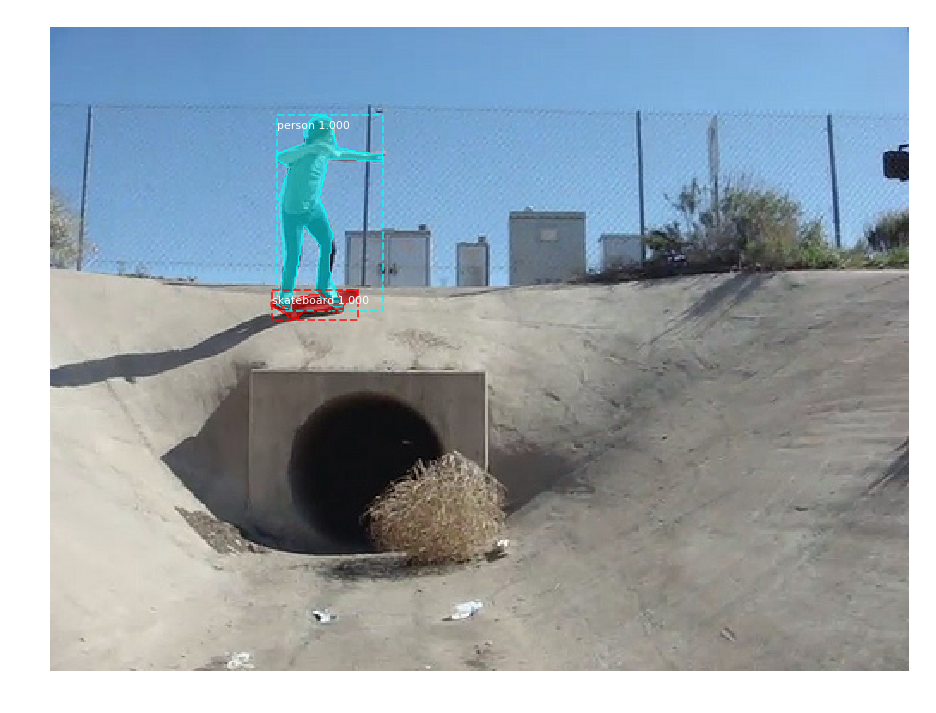

In [6]:
# Load a random image from the images folder

from pycocotools.coco import COCO
from pycocotools import mask as maskUtils

def convert_bbox(diff_style_bbox):
    y1 = diff_style_bbox[:, 0]
    x1 = diff_style_bbox[:, 1]
    y_diff = diff_style_bbox[:, 2]
    x_diff = diff_style_bbox[:, 3]
    y2 = y1 + y_diff
    x2 = x1 + x_diff
    return np.array([x1, y1, x2, y2]).transpose()

img_dir_name = '/Users/m_654132/Code/src/github.com/CognizantStudio/coco_mask_turker/data/val2017'
c = COCO('/Users/m_654132/Code/src/github.com/CognizantStudio/coco_mask_turker/data/annotations/instances_val2017.json')
c.createIndex()
c.info()

# img_id = 581615
img_id = 581062
print()
print('img_id', img_id)

imgs = c.loadImgs([img_id])
print()
print('imgs', imgs)
file_path = os.path.join(img_dir_name, imgs[0]['file_name'])

ann_ids = c.getAnnIds([img_id])
#print()
#print('ann_ids', ann_ids)

anns = c.loadAnns(ann_ids)
print()
print('anns', anns)

masks = np.array([c.annToMask(ann) for ann in anns])
#print()
#print('masks', masks)
#print('masks.shape', masks.shape)

masks = np.moveaxis(masks, 0, -1)
#print()
#print('masks', masks)
print('masks.shape', masks.shape)

#rois = np.array([list(map(round, ann['bbox'])) for ann in anns])
rois = np.array([maskUtils.toBbox(c.annToRLE(ann)) for ann in anns])
print('rois')
print(rois)
rois = convert_bbox(rois)
print(rois)
print('rois.shape', rois.shape)

class_ids = np.array([ann['category_id'] for ann in anns])

class_names = {cat['id']: cat['name'] for cat in c.loadCats(c.getCatIds())}
print()
print('class_names', class_names)

scores = np.ones(masks.shape[-1])

image = skimage.io.imread(file_path)

#print('asserted shapes')
#print(rois.shape[0])
#print(moved_masks.shape[-1])
#print(class_ids.shape[0])

visualize.display_instances(image, rois, masks, class_ids, 
                            class_names, scores)